In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('/content/sample_data/FeatureAll.csv')
df.head()

,label,ch1_stats/Col1_CrestFactor,ch_stats/Col1_Kurtosis,ch1_stats/Col1_RMS,ch1_stats/Col1_Std,ch2_stats/Col1_Mean,ch2_stats/Col1_RMS,ch2_stats/Col_Skewness,ch2_stats/Col1_Std,ch3_stats/Col1_CrestFactor,ch3_stats/Col1_SINAD,ch3_stats/Col1_SNR,ch3_stats/Col1_THD
0,0,2.368252,1.927020,2.222506,2.222490,-0.015149,0.625125,4.293144,0.624946,5.656937,-5.447553,-4.997680,-4.460752
1,0,2.401978,1.920552,2.180717,2.180281,-0.018269,0.567726,3.998453,0.567436,8.748129,-12.531508,-12.418675,-3.235284
2,0,2.415670,1.952337,2.178880,2.178832,-0.006365,0.456460,2.888567,0.456418,8.311148,-12.976609,-12.868510,-2.959078
3,0,2.459507,1.820543,2.140044,2.140052,0.001731,0.414178,2.063527,0.414178,7.231760,-13.565667,-13.467818,-2.794386
4,0,2.250243,1.860865,2.339061,2.339011,-0.008183,0.369402,3.349786,0.369314,6.813430,-13.330134,-13.224927,-2.718166


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=1)

In [ ]:
print(x_train.shape, x_valid.shape)

(14113, 13) (3529, 13)


#normalize

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)

In [ ]:
x_train_scaled = data_scaled.transform(x_train)
x_valid_scaled = data_scaled.transform(x_valid)

In [ ]:
normal_train_scaled = pd.DataFrame(x_train_scaled).add_prefix('c').query('c0 == 1').values[:,1:]
anomaly_train_scaled = pd.DataFrame(x_train_scaled).add_prefix('c').query('c0 == 0').values[:,1:]

In [ ]:
normal_valid_scaled = pd.DataFrame(x_valid_scaled).add_prefix('c').query('c0 == 1').values[:,1:]
anomaly_valid_scaled = pd.DataFrame(x_valid_scaled).add_prefix('c').query('c0 == 0').values[:,1:]

In [ ]:
print(normal_train_scaled.shape, anomaly_train_scaled.shape, normal_valid_scaled.shape, anomaly_valid_scaled.shape)

(9151, 12) (4962, 12) (2273, 12) (1256, 12)


#data 확인

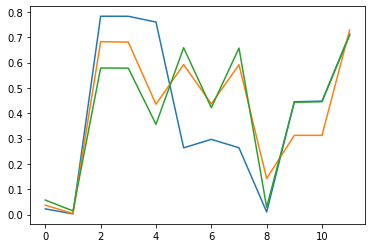

In [ ]:
plt.plot(normal_train_scaled[0])
plt.plot(normal_train_scaled[1])
plt.plot(normal_train_scaled[2])

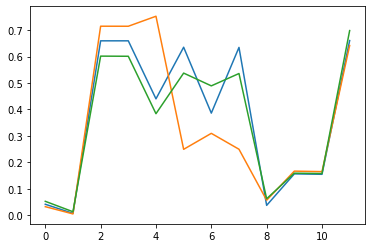

In [ ]:
plt.plot(anomaly_train_scaled[0])
plt.plot(anomaly_train_scaled[1])
plt.plot(anomaly_train_scaled[2])

#모델

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation = 'relu'),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(8, activation = 'relu'),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(8, activation = 'relu'),
            tf.keras.layers.Dense(16, activation = 'relu'),
            tf.keras.layers.Dense(32, activation = 'relu'),
            tf.keras.layers.Dense(64, activation = 'relu'),
            tf.keras.layers.Dense(12, activation = 'sigmoid')])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss = 'mae')

In [ ]:
history = autoencoder.fit(normal_train_scaled, normal_train_scaled,
                          epochs = 50,
                          batch_size = 128,
                          validation_data = (x_train_scaled[:,1:], x_train_scaled[:,1:]),
                          shuffle=True)

Epoch 1/50
72/72 [==============================] - 2s 10ms/step - loss: 0.1435 - val_loss: 0.0925
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0696 - val_loss: 0.0756
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0471 - val_loss: 0.0627
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0408 - val_loss: 0.0569
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0332 - val_loss: 0.0470
Epoch 6/50
72/72 [==============================] - 0s 5ms/step - loss: 0.0278 - val_loss: 0.0426
Epoch 7/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0416
Epoch 8/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0249 - val_loss: 0.0393
Epoch 9/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0234 - val_loss: 0.0395
Epoch 10/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0214 - val_loss: 0.0353
Epoch 11/50
72/72 

In [ ]:
encoder_out = autoencoder.encoder(normal_valid_scaled).numpy()
decoder_out = autoencoder.decoder(encoder_out).numpy()

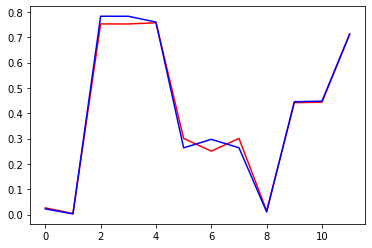

In [ ]:
plt.plot(decoder_out[0],'r')
plt.plot(normal_train_scaled[0],'b')

In [ ]:
encoder_out = autoencoder.encoder(anomaly_valid_scaled).numpy()
decoder_out = autoencoder.decoder(encoder_out).numpy()

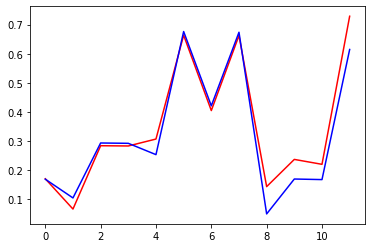

In [ ]:
plt.plot(decoder_out[0],'r')
plt.plot(anomaly_valid_scaled[0],'b')

72/72 [==============================] - 0s 2ms/step


(array([220., 533., 480., 359., 253., 117.,  99.,  39.,  29.,  39.,  17.,
         20.,  14.,  17.,   9.,   6.,   6.,   4.,   2.,   0.,   2.,   1.,
          0.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00249885, 0.00427151, 0.00604417, 0.00781683, 0.0095895 ,
        0.01136216, 0.01313482, 0.01490748, 0.01668015, 0.01845281,
        0.02022547, 0.02199813, 0.0237708 , 0.02554346, 0.02731612,
        0.02908878, 0.03086145, 0.03263411, 0.03440677, 0.03617943,
        0.0379521 , 0.03972476, 0.04149742, 0.04327008, 0.04504275,
        0.04681541, 0.04858807, 0.05036073, 0.0521334 , 0.05390606,
        0.05567872, 0.05745139, 0.05922405, 0.06099671, 0.06276937,
        0.06454204, 0.0663147 , 0.06808736, 0.06986002, 0.07163269,
        0.07340535, 0.07517801, 0.07695067, 0.07872334, 0.080496  ,
        0.08226866, 0.08404132, 0.08581399, 0.

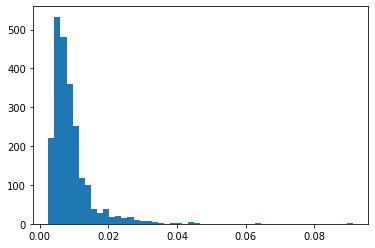

In [ ]:
reconstruction = autoencoder.predict(normal_valid_scaled)
loss = tf.keras.losses.mae(reconstruction, normal_valid_scaled)
plt.hist(loss, bins=50)

In [ ]:
np.mean(loss)

0.008908984070946938

In [ ]:
np.std(loss)

0.005758920954345986

In [ ]:
threshold = np.mean(loss) + 2*np.std(loss)
print(threshold)

0.020426825979638907


40/40 [==============================] - 0s 2ms/step


(array([ 3.,  5., 24., 35., 36., 35., 39., 44., 46., 39., 52., 36., 41.,
        53., 62., 63., 62., 54., 70., 56., 64., 51., 41., 40., 34., 29.,
        17., 31., 19., 17., 17.,  8.,  6.,  7.,  3.,  4.,  4.,  0.,  3.,
         0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([0.01250642, 0.01382288, 0.01513934, 0.01645581, 0.01777227,
        0.01908873, 0.02040519, 0.02172165, 0.02303812, 0.02435458,
        0.02567104, 0.0269875 , 0.02830396, 0.02962043, 0.03093689,
        0.03225335, 0.03356981, 0.03488628, 0.03620274, 0.0375192 ,
        0.03883566, 0.04015212, 0.04146859, 0.04278505, 0.04410151,
        0.04541797, 0.04673443, 0.0480509 , 0.04936736, 0.05068382,
        0.05200028, 0.05331674, 0.05463321, 0.05594967, 0.05726613,
        0.05858259, 0.05989905, 0.06121552, 0.06253198, 0.06384844,
        0.0651649 , 0.06648136, 0.06779783, 0.06911429, 0.07043075,
        0.07174721, 0.07306368, 0.07438014, 0.0756966 , 0.07701306,
        0.07832952]),
 <a list of 50

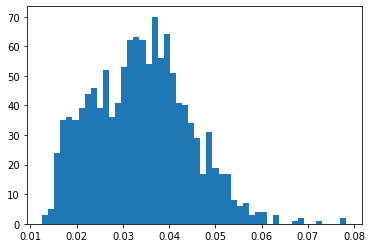

In [ ]:
anomaly_reconstruction = autoencoder.predict(anomaly_valid_scaled)
anomaly_loss = tf.keras.losses.mae(anomaly_reconstruction, anomaly_valid_scaled)
plt.hist(anomaly_loss, bins=50)

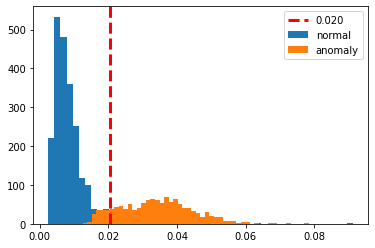

In [ ]:
plt.hist(loss, bins=50, label='normal')
plt.hist(anomaly_loss, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.mean(anomaly_loss)

0.033971889289499235

In [ ]:
np.std(anomaly_loss)

0.01047863704951427

In [ ]:
preds = tf.math.less(loss, threshold)
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=2171>

In [ ]:
preds.shape

TensorShape([2273])

In [ ]:
anomaly_preds = tf.math.greater(anomaly_loss, threshold)
tf.math.count_nonzero(anomaly_preds)

<tf.Tensor: shape=(), dtype=int64, numpy=1118>

In [ ]:
anomaly_preds.shape

TensorShape([1256])